In [20]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [21]:
autoencoder = tf.keras.models.load_model('../modelos/autoencoder_model.keras')

c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [51]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                   "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                   "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                   "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == 1) & 
                                (dados.iloc[:, 9] == 0)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == 1) & 
                                (dados.iloc[:, 9] == 0)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:17000]

ids_ecgs= ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 104171
Número de linhas ecg_doente_linhas: 5352
Tirando Interferência:
Número de linhas ecg_normal_linhas: 101302
Número de linhas ecg_doente_linhas: 5259
Número de ecgs pra clusterizar: 22259


In [52]:
#X
arquivos_hdf5 = ["../Database/filtered_exams_2_3.hdf5",  "../Database/filtered_exams_4_5.hdf5",
                 "../Database/filtered_exams_6_7.hdf5",  "../Database/filtered_exams_8_9.hdf5",
                 "../Database/filtered_exams_10_11.hdf5",  "../Database/filtered_exams_12_13.hdf5",
                 "../Database/filtered_exams_14_15.hdf5", "../Database/filtered_exams_16_17.hdf5"]

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
    for arquivo in arquivos_hdf5:
        try:
            tracings = get_ecg_data(arquivo, exam_id)
            if tracings is not None:
                tracing_transposto = np.array(tracings).T
                all_tracings.append(tracing_transposto)
                found = True  # Sinalizador para indicar que o exame foi encontrado
                break  # Se encontrou, não precisa continuar buscando nos outros arquivos
        except ValueError as e:
            i = 0
        except Exception as e:
            i = 0
    
    if not found:
        print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

# Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
print(f"Número total de traçados processados: {len(all_tracings)}")

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])

Número de ecgs que eram pra ser processados: 22259
Número total de traçados processados: 22259


In [53]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

# Substituir os valores NaN por epsilon
epsilon = 1e-10
X_encoded_2d = np.nan_to_num(X_encoded_2d, nan=epsilon)

696/696 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step
(22259, 128, 1)
(22259, 128)


In [69]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.05, n_components=8, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

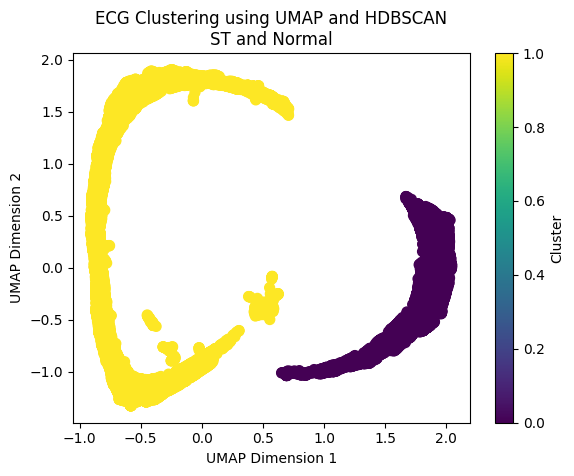

Silhouette Score: 0.18346773087978363
   cluster  1dAVb  RBBB  LBBB  SB    ST  AF  normal_ecg
0        0      0     0     0   0  4685   0         199
1        1      0     0     0   0   574   0       16801


In [71]:
#CLUSTERIZACAO HDBSCAN
scaler2 = StandardScaler()
X_reduced_scaled = scaler2.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=500, min_samples=1, cluster_selection_epsilon=2)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN\nST and Normal')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
exam_ids_to_cluster = ids_ecgs

cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

In [48]:
#CODE_TESTE_TODO

#CARREGAR OS DADOS
caminho_arquivo = "gold_standard_id.csv"
dados = pd.read_csv(caminho_arquivo)


ecg_normal_linhas = dados.index[
                                (dados.iloc[:, 1] == 0) & 
                                (dados.iloc[:, 2] == 0) & 
                                (dados.iloc[:, 3] == 0) & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 0) & 
                                (dados.iloc[:, 6] == 0)]

ecg_doente_linhas = dados.index[
                                (dados.iloc[:, 1] == 0) & 
                                (dados.iloc[:, 2] == 0) & 
                                (dados.iloc[:, 3] == 0) & 
                                (dados.iloc[:, 4] == 0) & 
                                (dados.iloc[:, 5] == 0) & 
                                (dados.iloc[:, 6] == 1)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

#ecg_doente = ecg_doente_id[]
ecg_normal = ecg_normal_id[:10000]

ids_ecgs_treino= ecg_doente_id + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs_treino))

import h5py
import numpy as np
import pandas as pd

# Arquivos
hdf5_file = 'ecg_tracings.hdf5'
gold_standard_file = 'gold_standard_id.csv'

# Passo 1: Ler o arquivo HDF5 com os traçados ECG
with h5py.File(hdf5_file, "r") as f:
    tracings = np.array(f['tracings'])

# Passo 2: Ler o arquivo CSV
df = pd.read_csv(gold_standard_file)

# Passo 4: Colocar todos os traçados na ordem dos IDs de exame em um vetor
# Filtrar os traçados pelos IDs selecionados
ordered_tracings = []
for exam_id in ids_ecgs_treino:
    if exam_id < len(tracings):
        ordered_tracings.append(tracings[exam_id])

# Converter a lista para um array numpy
ordered_tracings = np.array(ordered_tracings)

# Passo 5: Aplicar o filtro em todos os leads de todos os exames
filtered_tracings = np.zeros_like(ordered_tracings)

for i in range(ordered_tracings.shape[0]):
    for lead in range(ordered_tracings.shape[2]):  # Iterar sobre os 12 leads
        filtered_tracings[i, :, lead] = ecg_filtrado(ordered_tracings[i, :, lead])

# Exemplo: Imprimir informações sobre o primeiro exam_id e seu traçado filtrado correspondente
first_exam_id = df['exam_id'].iloc[0]
first_filtered_tracing = filtered_tracings[0]


X_TREINO = np.array(filtered_tracings)
 
# Usando squeeze
X_TREINO = np.squeeze(X_TREINO[:, :, 1])

Número de linhas ecg_normal_linhas: 681
Número de linhas ecg_doente_linhas: 35
Número de ecgs pra clusterizar: 716


In [56]:
#DIMINUIR DIMENSAO DE X_TREINO PELO AUTOENCODER(128)
autoencoder = tf.keras.models.load_model('../modelos/autoencoder_model.keras')
# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X_TREINO = X_TREINO / np.max(np.abs(X_TREINO), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X_TREINO = X_TREINO.reshape((X_TREINO.shape[0], X_TREINO.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X_TREINO
X_TREINO_encoded = encoder.predict(X_TREINO)

# X_encoded agora contém os vetores de 128 números para cada entrada em X_TREINO
print(X_TREINO_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_TREINO_encoded_2d = np.squeeze(X_TREINO_encoded)
print(X_TREINO_encoded_2d.shape)  # Deve ser (10500, 128)
print(len(X_TREINO_encoded_2d))

# Substituir os valores NaN por epsilon

print(len(X_TREINO_encoded_2d))


c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
(716, 128, 1)
(716, 128)
716
716


In [73]:
#DIMINUIR DIMENSAO DE X_TREINO PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
X_TREINO_normalized = scaler.transform(X_TREINO_encoded_2d)
# Aplicação do UMAP
print(len(X_TREINO_normalized))
X_TREINO_reduced = umap_reducer.transform(X_TREINO_normalized)
print(len(X_TREINO_reduced))

X_TREINO_reduced_scaled = scaler2.transform(X_TREINO_reduced)
print(len(X_TREINO_reduced_scaled))


716
716
716


716


c:\Users\pedro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


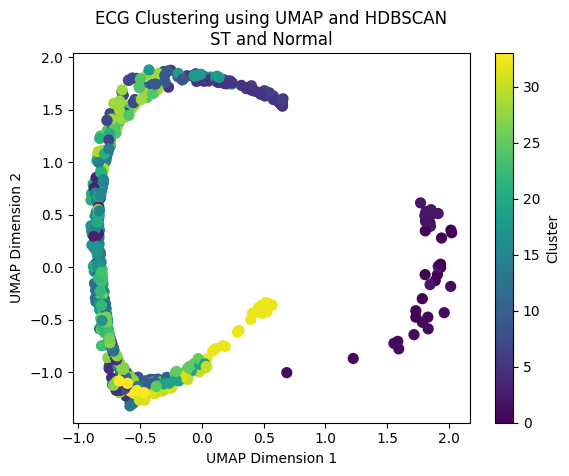

Silhouette Score: 0.37512412667274475
716
F1 Score: 0.030295313687542604
    cluster  1dAVb  RBBB  LBBB  SB  ST  AF  normal_ecg
0         0      0     0     0   0  12   0           2
1         1      0     0     0   0  10   0           1
2         2      0     0     0   0   8   0           6
3         3      0     0     0   0   1   0          21
4         4      0     0     0   0   0   0          25
5         5      0     0     0   0   0   0          37
6         6      0     0     0   0   0   0          13
7         7      0     0     0   0   0   0          24
8         8      0     0     0   0   0   0          16
9         9      0     0     0   0   0   0          24
10       10      0     0     0   0   0   0          16
11       11      0     0     0   0   0   0           7
12       12      0     0     0   0   0   0          18
13       13      0     0     0   0   0   0          10
14       14      0     0     0   0   0   0          21
15       15      0     0     0   0   0   0     

C:\Users\pedro\AppData\Local\Temp\ipykernel_17140\626762358.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()


In [79]:
#CLUSTERIZACAO HDBSCAN
from sklearn.metrics import silhouette_score, f1_score
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

# Instanciando o Affinity Propagation
affinity_propagation = AffinityPropagation(random_state=42)

# Ajustando o modelo e obtendo os rótulos (labels)
labels = affinity_propagation.fit_predict(X_TREINO_reduced_scaled)
print(len(labels))
# Visualização dos Resultados
plt.scatter(X_TREINO_reduced_scaled[:, 0], X_TREINO_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN\nST and Normal')
plt.colorbar(label='Cluster')
plt.show()

# Calcular e imprimir os scores
silhouette_avg = silhouette_score(X_TREINO_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Carregar os dados do CSV
metadata = pd.read_csv("gold_standard_id.csv")
exam_ids_to_cluster = ids_ecgs_treino
print(len(exam_ids_to_cluster))

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Determinar o rótulo verdadeiro para cada cluster com base na maioria
def determine_majority_label(cluster_data):
    normal_count = cluster_data['normal_ecg'].sum()
    disease_count = cluster_data[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum().sum()
    return 'normal' if normal_count > disease_count else 'disease'

# Aplicar a função para determinar o rótulo majoritário de cada cluster
majority_labels = merged_data.groupby('cluster', group_keys=False).apply(determine_majority_label).reset_index()
majority_labels.columns = ['cluster', 'majority_label']

# Mesclar os rótulos majoritários com os dados agrupados
merged_data = merged_data.merge(majority_labels, on='cluster')

# Criar rótulos verdadeiros
def assign_true_label(row):
    if row['majority_label'] == 'normal':
        return row['normal_ecg'] == 1
    else:
        return row[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].sum() > 0

merged_data['true_label'] = merged_data.apply(assign_true_label, axis=1)

# Calcular o F1 score
true_labels = merged_data['true_label']
f1_avg = f1_score(true_labels, labels, average='weighted')
print(f'F1 Score: {f1_avg}')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)